# HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [3]:
def svd_k(X, k):
    # Compute covariance matrix
    C = np.dot(X.T, X)
    # SVD decomposition
    U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
    # Limit the number columns of U to k
    U_k=U[:,:k]
    return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? Test  and discuss the results in a new cell after the following one.

In [4]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



#### Discussion
Based on PCA, the columns of $U$ represents a orthogonal basis for the columns of $X$. Hence, if we reduce the number of dimensions of $U$, we are essentially compressing the data more, by limiting the architecture to encode fewer dimensions of the data, by simply removing certain vectors/columns from the basis. From varying the ENCODING_DIM from high to low, we see that this makes sense as the MSE increases for lower values of ENCODING_DIM:
1. Dim of 500 -> Test MSE of 0.00005 versus 
2. Dim of 120 -> Test MSE of 0.00455

Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)

In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [7]:
def plot_img(n, input_data, decoded_imgs):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(input_data[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

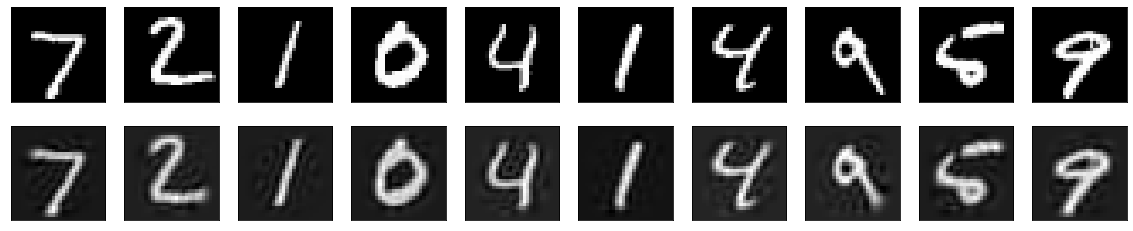

In [8]:
plot_img(10, x_test, x_test_reco)

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [9]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [11]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 2s 19ms/step - loss: 0.0815 - val_loss: 0.0140
Epoch 2/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0126 - val_loss: 0.0086
Epoch 3/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 5/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 6/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 8/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 9/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [12]:
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.title('loss')

313/313 - 0s - loss: 0.0051
test mse: 0.00505


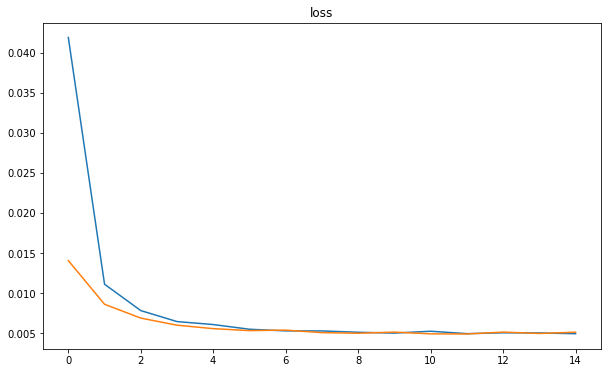

In [13]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

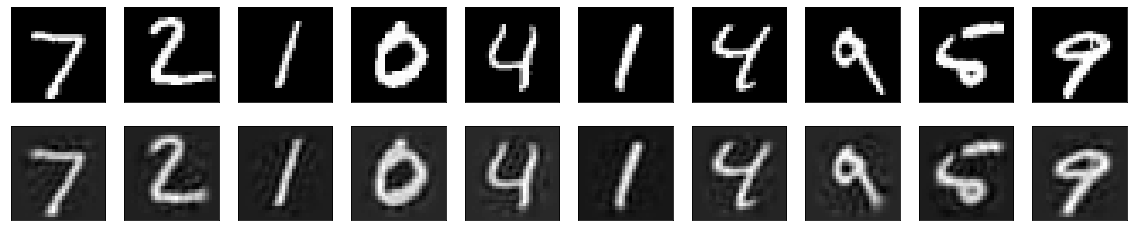

In [14]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


#### Discussion
The shallow linear autoencoder performs roughly similar in terms of performance, where the test MSEs are roughly similar for an encoder dimension of 120 and lower. However, when not constraining the dimension of the encoder, i.e. allowing it to be 784, we observe that, while the SVD is able to fully encode the data with MSE of 0, the shallow linear autoencoder is not able to do the same, having a test MSE of 0.00138.

1. Dim of 30 -> SVD: 0.01771, Shallow linear autoencoder: 0.01816
2. Dim of 120 -> SVD: 0.00455, Shallow linear autoencoder: 0.00505
3. Dim of 784 -> SVD: 0.00000, Shallow linear autoencoder: 0.00138

This is probably because the SVD is an analytical decomposition, i.e. if the dimension allows, then it is able to fully represent the data through $U$, $S$ and $V$ (or $U$ and $S^2$). In contrast, the shallow linear autoencoder has to learn the features of the data with the encoder, which is not as precise. However, for small encoder dimensions, we see that the outputs are very alike, where the precise decomposition of SVD does not make a large difference after "compression" compared with the shallow linear autoencoder.

Moreover, we also see note that doing the SVD is much quicker than the shallow linear autoencoder, probably since our PC can manage the U_d matrix decomposition quickly compared to doing many gradient descents in the linear autoencoder fitting.


## [TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. (Insert your code and  theoretical discussion into  cells immediately below this one.)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 2s 17ms/step - loss: 0.0747 - val_loss: 0.0348
Epoch 2/15
98/98 [==============================] - 1s 14ms/step - loss: 0.0312 - val_loss: 0.0223
Epoch 3/15
98/98 [==============================] - 2s 15ms/step - loss: 0.0208 - val_loss: 0.0163
Epoch 4/15
98/98 [==============================] - 1s 15ms/step - loss: 0.0155 - val_

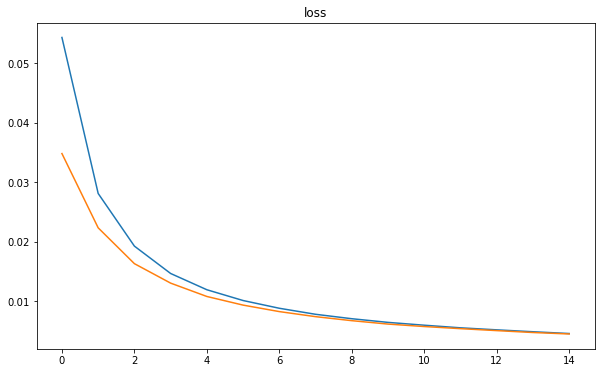

In [15]:
ENCODING_DIMs = [120]

for ENCODING_DIM in ENCODING_DIMs:
    input_img = tf.keras.layers.Input(shape=(784,))
    #Define the encoder...
    encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

    #...and the decoder...
    decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

    #and finally the autoencoder
    autoencoder = tf.keras.models.Model(input_img, decoded)

    # In order to visualize the learned encoding, define a model that computes the 
    # two parts separately.
    encoder = tf.keras.models.Model(input_img, encoded)
    encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
    decoder_layer = autoencoder.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

    #Finally, let's call the compile method
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

    autoencoder.summary()
    history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, 
                              shuffle=True, validation_data=(x_valid, x_valid))

    plot_loss(history)

    scores = autoencoder.evaluate(x_test, x_test, verbose=2)
    print("test mse: %.5f" % (scores))

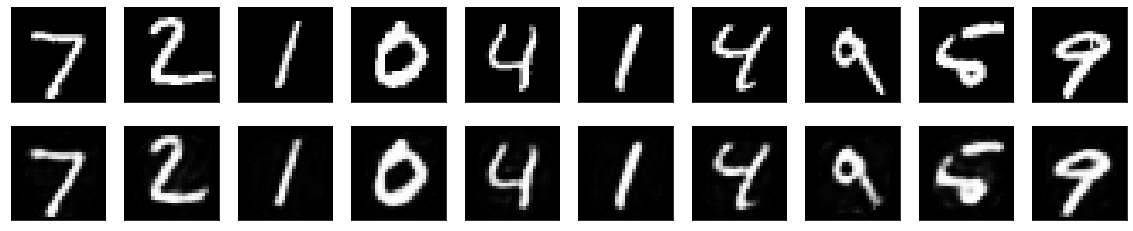

In [16]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

#### Discussion

As the nonlinear activation function I chose the *sigmoid* function. This is mainly because it has a range of [0,1], which matches the range of our input. These qualities can be motivated by the goal of the autoencoder: we wish that our output is representative of our input. Hence, we wish that our input range should be preserved.

Some tests:

1. Dim of 30 -> test mse: 0.05316 with both sigmoid, 0.01956 with relu on encoded layer
2. Dim of 120 -> test mse: 0.00440 with both sigmoid, 0.01565 with relu on encoded layer
3. Dim of 784 -> test mse: 0.00353

##### Relu versus Sigmoid

After some experimentation, it seems like the last layer should use a *sigmoid* activation function while the encoded layer could actually have another activation function, e.g. *ReLU* (Note, when referring to *ReLU*, I mean ReLU activation function on the encoded layer and sigmoid on the ouput layer).
The results are varying, where I received better results with *ReLU* for smaller encoder dimensions but much better results with *sigmoid* for dimensions closer to 120 and above.

The reason for this is not entirely clear, but we see that the performance of the *ReLU* is close to the performance of the linear methods (MSE of 0.01956 versus SVD: 0.01771, Shallow linear autoencoder: 0.01816) for a dimension of 30. Perhaps this is because the *ReLU* is linear for the whole input range, and only *slightly* nonlinear, and so it is able to match the linear performance compared to the *sigmoid*. Also, using a *ReLU* for the encoded layer allows for a more sparse representation of the data, where values that are 0 in the input are actually 0 in the activation (using *ReLU* compared to a *sigmoid*). So, we can argue this allows the model to learn more compact representations of the data, which is important when we're limited to only an encoding dimension of 30.


##### Nonlinear versus linear shallow autoencoders
On the contrary, for an encoding dimension of 120, we see that the *sigmoid* outperforms both the SVD and linear shallow autoencoder (MSE of 0.00433 versus SVD: 0.00455, Shallow linear autoencoder: 0.00505). This is interesting and could be explained by the nonlinearities introduced in using the *sigmoid*, which allows the model to learn more complex functions than just a linear one, and so is more effective at encoding the input with fewer dimensions. Moreover, is also noteworthy that the sigmoid also outperforms the *ReLU* version (MSE of 0.01593), however the reason for this is not so clear.

## [TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 2s 16ms/step - loss: 0.1242 - val_loss: 0.0487
Epoch 2/15
98/98 [==

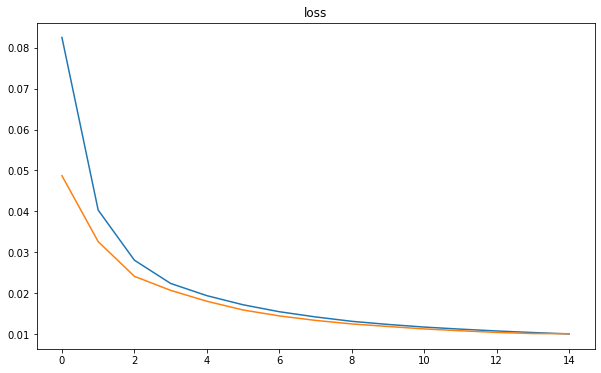

In [17]:
HIDDEN_DIM = 128
ENCODING_DIM = 64

input_img = tf.keras.layers.Input(shape=(784,))
encoding_1 = tf.keras.layers.Dense(HIDDEN_DIM, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(encoding_1)
decoding_1 = tf.keras.layers.Dense(HIDDEN_DIM, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoding_1)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 512, 
                          shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

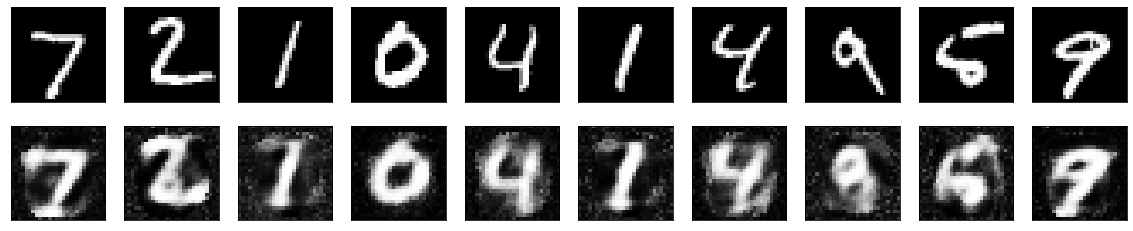


sigmoid for all : not so good
sigmoid for encoded: test mse: 0.01894
relu for all:  test mse: 0.00987

Much better than shallow nonlinear autoencoder with only a few more params, still 
worse than linear.



In [33]:
decoded_imgs = autoencoder.predict(x_test)
plot_img(10, x_test, decoded_imgs)

print('''
sigmoid for all : not so good
sigmoid for encoded: test mse: 0.01894
relu for all:  test mse: 0.00987

Much better than shallow nonlinear autoencoder for small with only a few more params, 
still worse than linear.
''')

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.
**NOTE: in the code at the bottom noise_factor is added and not multiplied for numerical reasons. You may want to try the version with multiplication to verify it is more unstable.**

In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

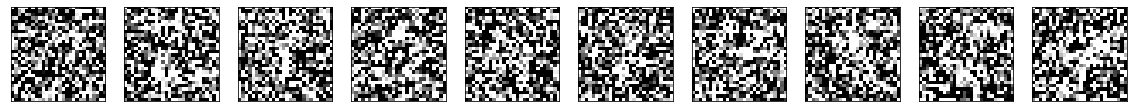

In [20]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [21]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 120)               94200     
_________________________________________________________________
dense_9 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [22]:
history = autoencoder.fit(x_train_noisy, x_train, epochs= 15, batch_size= 512, 
                          shuffle=True, validation_data=(x_valid_noisy, x_valid))


Epoch 1/15
98/98 [==============================] - 3s 21ms/step - loss: 0.1097 - val_loss: 0.0661
Epoch 2/15
98/98 [==============================] - 2s 20ms/step - loss: 0.0630 - val_loss: 0.0541
Epoch 3/15
98/98 [==============================] - 2s 18ms/step - loss: 0.0524 - val_loss: 0.0480
Epoch 4/15
98/98 [==============================] - 2s 16ms/step - loss: 0.0471 - val_loss: 0.0450
Epoch 5/15
98/98 [==============================] - 1s 12ms/step - loss: 0.0443 - val_loss: 0.0429
Epoch 6/15
98/98 [==============================] - 1s 12ms/step - loss: 0.0424 - val_loss: 0.0415
Epoch 7/15
98/98 [==============================] - 1s 12ms/step - loss: 0.0410 - val_loss: 0.0405
Epoch 8/15
98/98 [==============================] - 1s 12ms/step - loss: 0.0400 - val_loss: 0.0398
Epoch 9/15
98/98 [==============================] - 1s 13ms/step - loss: 0.0391 - val_loss: 0.0392
Epoch 10/15
98/98 [==============================] - 1s 12ms/step - loss: 0.0385 - val_loss: 0.0387
Epoch 11/

313/313 - 0s - loss: 0.0369
test mse: 0.03687


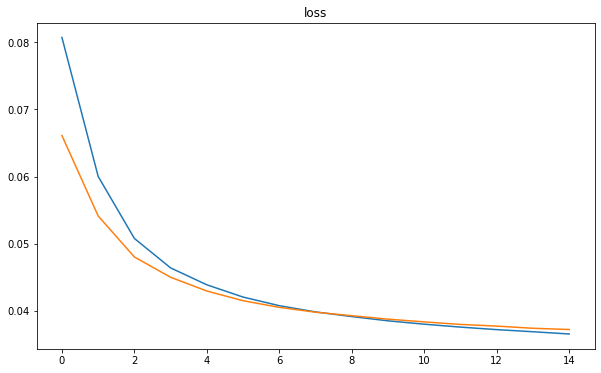

In [23]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

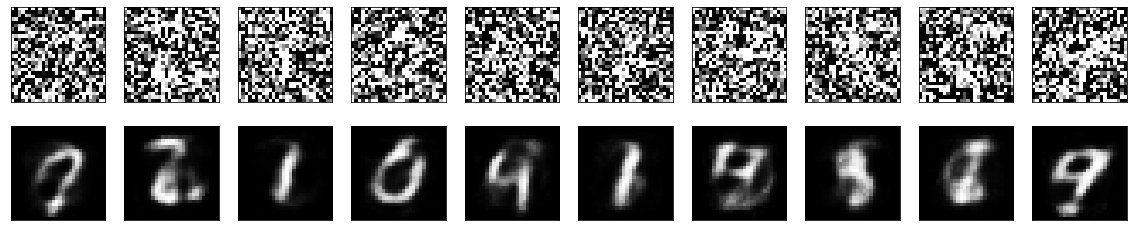

In [24]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [25]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

word_index = {word: word_id for word_id, word in reverse_index.items()}

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

rev = '''hello world and friends wow who would have thought that this thing actually works
test now that is a very good movie and i liked it a lot my favorite part is the best part
and i would recommend this to all'''.split()
X_test[0] = np.array([word_index[word] if word_index[word] < 100 else 2 for word in rev])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/patricknitschke/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/patricknitschke/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different le

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [26]:
from tensorflow.keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [27]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 7s 76ms/step - loss: 0.3633 - categorical_accuracy: 0.0134 - val_loss: 0.1089 - val_categorical_accuracy: 0.1409
Epoch 2/50
79/79 [==============================] - 6s 74ms/step - loss: 0.0930 - categorical_accuracy: 0.2481 - val_loss: 0.0663 - val_categorical_accuracy: 0.4746
Epoch 3/50
79/79 [==============================] - 6s 73ms/step - loss: 0.0660 - categorical_accuracy: 0.4782 - val_loss: 0.0596 - val_categorical_accuracy: 0.5145
Epoch 4/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0558 - categorical_accuracy: 0.5383 - val_loss: 0.0514 - val_categorical_accuracy: 0.5530
Epoch 5/50
79/79 [==============================] - 6s 71ms/step - loss: 0.0487 - categorical_accuracy: 0.5686 - val_loss: 0.0467 - val_categorical_accuracy: 0.5669
Epoch 6/50
79/79 [==============================] - 6s 73ms/step - loss: 0.0445 - categorical_accuracy: 0.5848 - val_loss: 0.0426 - val_categorical_accuracy: 0.5998
Epoch 7/50

79/79 [==============================] - 6s 74ms/step - loss: 0.0126 - categorical_accuracy: 0.9297 - val_loss: 0.0134 - val_categorical_accuracy: 0.9241


Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0127 - categorical_accuracy: 0.9286
categorical_accuracy: 92.86%


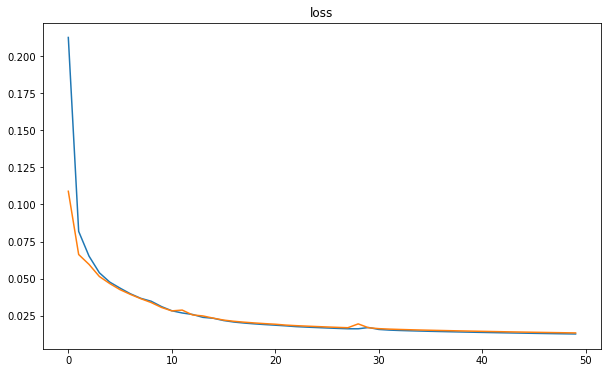

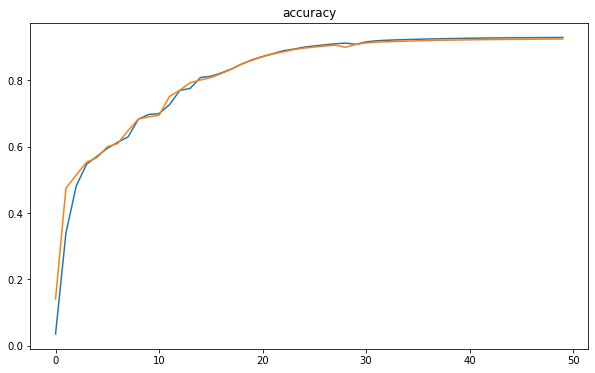

In [29]:
def plot_categorical_accuracy(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['categorical_accuracy'])
    plt.plot(history.epoch,history.history['val_categorical_accuracy'])
    plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [30]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[0], axis=1)
input_text= np.argmax(X_test_one_hot[0], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <oov> <oov> and <oov> <oov> who would have <oov> that this <oov> <oov> <oov> <oov> <oov> that is a very good movie and i <oov> it a <oov> my <oov> <oov> is the <oov> <oov> and i would <oov> this to all
it of of of this much much this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this this <oov> <oov> and <oov> <oov> who i have <oov> that this <oov> <oov> <oov> <oov> <oov> that is a great good movie and i <oov> it a <oov> my <oov> <oov> is the <oov> <oov> and i would <oov> this to all


## [TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [38]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, activation='tanh', return_sequences=True)(inputs)
decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 14s 152ms/step - loss: 0.5069 - categorical_accuracy: 0.0650 - val_loss: 0.0770 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 13s 160ms/step - loss: 0.0676 - categorical_accuracy: 0.4721 - val_loss: 0.0548 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] 

79/79 [==============================] - 9s 108ms/step - loss: 0.0092 - categorical_accuracy: 0.9271 - val_loss: 0.0089 - val_categorical_accuracy: 0.9323
Epoch 46/50
79/79 [==============================] - 9s 114ms/step - loss: 0.0085 - categorical_accuracy: 0.9368 - val_loss: 0.0082 - val_categorical_accuracy: 0.9482
Epoch 47/50
79/79 [==============================] - 13s 167ms/step - loss: 0.0079 - categorical_accuracy: 0.9507 - val_loss: 0.0076 - val_categorical_accuracy: 0.9621
Epoch 48/50
79/79 [==============================] - 13s 167ms/step - loss: 0.0073 - categorical_accuracy: 0.9648 - val_loss: 0.0070 - val_categorical_accuracy: 0.9699
Epoch 49/50
79/79 [==============================] - 15s 188ms/step - loss: 0.0067 - categorical_accuracy: 0.9721 - val_loss: 0.0065 - val_categorical_accuracy: 0.9765
Epoch 50/50
79/79 [==============================] - 13s 162ms/step - loss: 0.0062 - categorical_accuracy: 0.9782 - val_loss: 0.0060 - val_categorical_accuracy: 0.9815


40/40 - 1s - loss: 0.0059 - categorical_accuracy: 0.9817
categorical_accuracy: 98.17%


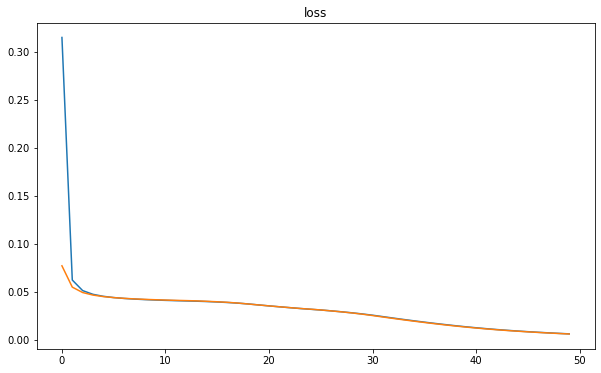

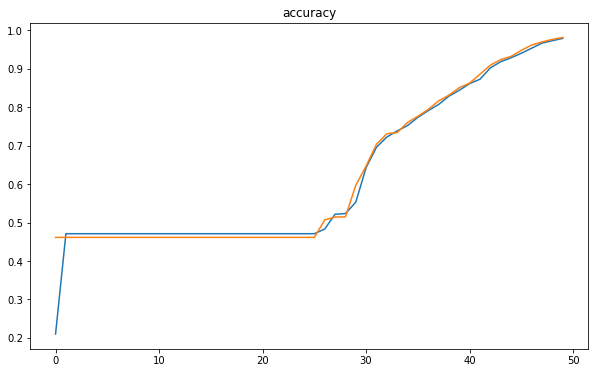

In [39]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

#### Discussion

##### Choice of activation

We can first note that our loss function of choice is 'binary_crossentropy', which calculates the loss from a binary classification problem of 0 and 1, matching our one-hot transformed data. Naturally, we then choose the *sigmoid* activation function for the decoder/output layer as we wish the map our encoded data into the original input range of [0,1].
As for the hidden layer, we can experiment with different activations functions:
(Performances with various activation functions on for encoded layer, but keeping sigmoid for output)
1. Default *Tanh*, categorical_accuracy: 98.55%
2. *sigmoid*, categorical_accuracy: 95.38%
3. *ReLU*, categorical_accuracy: 60.70%

We achieved the best performance using the default *tanh* activation function. This was also my initial guess, given that *tanh* is the most commonly used activation. To consider why it's doing better, perhaps it could be because *tanh* is known to have faster convergence than *sigmoid*. In this case with quite slow learning, we see that maybe a faster converge could lead to a difference in performance. Next, we see that using a *ReLU* activation function on the output yields poor performance, maybe because it is not as suited for this data type, and also reflects why it's not as popular in LSTMs.

So, the best choice here is the *tanh* activation function for hidden layer, and *sigmoid* for output.

##### Nonlinear versus linear autoencoder for sequences
Performances:
1. Linear autoencoder categorical_accuracy: 92.86%
2. Nonlinear autoencoder categorical_accuracy: 98.36%

Initially, we see that the linear autoencoder does very well at encoding sequences and maintaining a high accuracy of 92.68%. However, the LSTM nonlinear performs much better at an accuracy of 98.36%. So where do we credit this better performance? The nonlinear autoencoder has two main differences: the LSTM encoded layer and its nonlinear activation functions.

It is difficult to say whether one or the other differences are the cause of the performance increase, but based on the the nonlinear and linear autoencoder comparisons in Exercise 5.3, where we saw that best performances varies between both the linear and nonlinear versions, I would guess that the LSTM architecture has a lot to say.

Yet, we see that choosing the right activation function also has much to say, where choosing for example the *sigmoid* results in a significant 3% lower-than-optimal performance. Still, these nonlinear activation functions generally performed better than its linear counterpart, suggesting - as also mentioned earlier - that the nonlinearities introduced into the model allows the model to learn more complex relationships in the data than just linear ones, and therefore can perform better.